In [81]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor as pt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
# Load data
df = pd.read_csv("Fake_Game_Dataset.csv")
alpha_data = df['alpha'].values
beta_data = df['beta'].values
gamma_data = df['gamma'].values
X_data = df['X'].values

# PyMC Model
with pm.Model() as model:
    # Priors
    r1 = pm.Uniform('r1', lower=-1, upper=4)
    r2 = pm.Uniform('r2', lower=-4, upper=4)
    r3 = pm.Uniform('r3', lower=-1, upper=4)
    delta = pm.Uniform('delta', lower=0, upper=4)
    log_m = pm.Normal("log_m", mu=2.5, sigma=1.0)
    m = pm.Deterministic("m", pm.math.minimum(pm.math.exp(log_m), 50.0))

    # Relative strength
    lambda_ = alpha_data**r1 * beta_data**r2 * gamma_data**r3
    lambda_delta = lambda_ * delta

    # Beta distribution shape parameters
    a = m * lambda_delta
    b = m

    # Sample win probabilities from Beta distribution
    p_s = pm.Beta('p_s', alpha=a, beta=b, shape=len(X_data))

    # Likelihood
    X_obs = pm.Bernoulli('X_obs', p=p_s, observed=X_data)

    # Inference
    trace = pm.sample(2000, tune=1000, target_accept=0.95, cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r1, r2, r3, delta, log_m, p_s]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


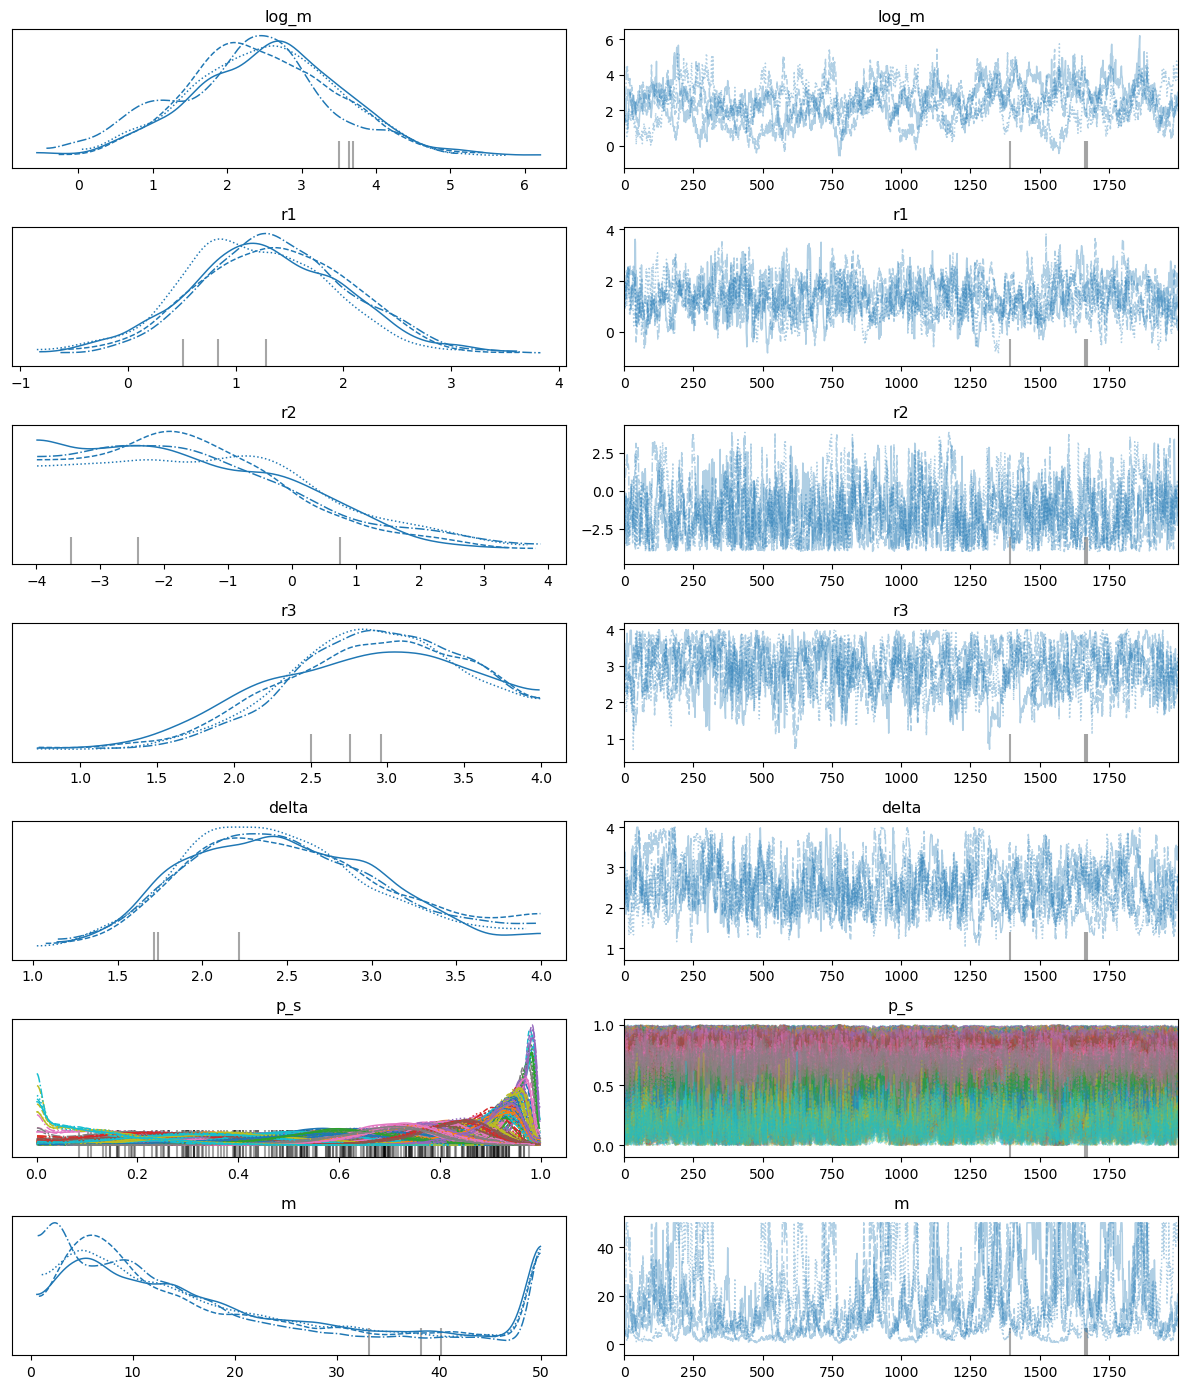

In [57]:
import arviz as az
import matplotlib.pyplot as plt

# Plot trace for all parameters
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [58]:
def get_posterior_win_prob(trace, alpha_s, beta_s, gamma_s):
    # Extract 1D arrays from posterior
    def extract(var):
        return trace.posterior[var].stack(sample=("chain", "draw")).values  # shape (n_samples,)

    r1_samples = extract("r1")
    r2_samples = extract("r2")
    r3_samples = extract("r3")
    delta_samples = extract("delta")
    m_samples = extract("m")

    # Ensure everything is 1D (flatten just in case)
    r1_samples = r1_samples.flatten()
    r2_samples = r2_samples.flatten()
    r3_samples = r3_samples.flatten()
    delta_samples = delta_samples.flatten()
    m_samples = m_samples.flatten()

    # Calculate lambda for each posterior sample
    lambda_s = (alpha_s ** r1_samples) * (beta_s ** r2_samples) * (gamma_s ** r3_samples)

    # Shape parameters for the Beta distribution
    a_params = m_samples * lambda_s * delta_samples
    b_params = m_samples

    # Ensure same shape
    assert a_params.shape == b_params.shape == lambda_s.shape

    # Sample win probabilities
    p_samples = np.random.beta(a_params, b_params)  # shape (n_samples,)
    return p_samples


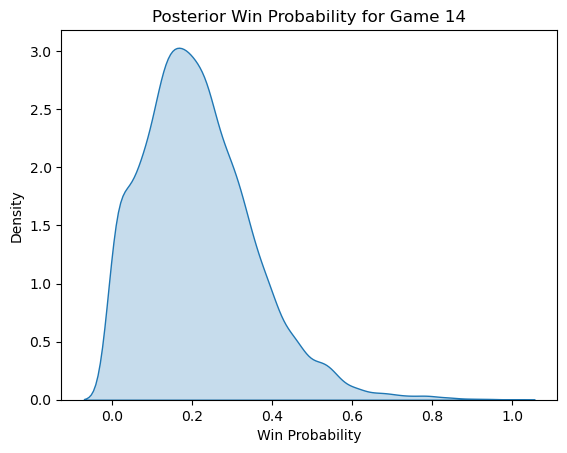

In [59]:
# === Example: pick game 0 from dataset ===
idx = 14
alpha_s = alpha_data[idx]
beta_s = beta_data[idx]
gamma_s = gamma_data[idx]
p_samples = get_posterior_win_prob(trace, alpha_s, beta_s, gamma_s)

# Plot posterior distribution of win probability
sns.kdeplot(p_samples, fill=True)
plt.title(f"Posterior Win Probability for Game {idx}")
plt.xlabel("Win Probability")
plt.ylabel("Density")
plt.show()

In [60]:
from tqdm import tqdm
import numpy as np

# Prepare predictions
y_true = df['X'].values
y_pred = []
hdi_low_list = []
hdi_high_list = []

for a, b, g in tqdm(zip(df['alpha'], df['beta'], df['gamma']), total=len(df)):
    p_samples = get_posterior_win_prob(trace, a, b, g)
    hdi_low = np.percentile(p_samples, 3)
    hdi_high = np.percentile(p_samples, 97)

    hdi_low_list.append(hdi_low)
    hdi_high_list.append(hdi_high)

    if hdi_low > 0.5:
        y_pred.append(1)
    elif hdi_high < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(None)  # Uncertain prediction

# Evaluate
y_true_valid = [yt for yp, yt in zip(y_pred, y_true) if yp is not None]
y_pred_valid = [yp for yp in y_pred if yp is not None]

accuracy = np.mean(np.array(y_pred_valid) == np.array(y_true_valid))
coverage = len(y_pred_valid) / len(y_true)

print(f"Accuracy on confident predictions: {accuracy:.3f}")
print(f"Coverage (fraction of games predicted): {coverage:.3f}")


100%|██████████| 100/100 [00:00<00:00, 447.14it/s]

Accuracy on confident predictions: 0.911
Coverage (fraction of games predicted): 0.450


In [61]:
from tqdm import tqdm
import numpy as np

y_true = df['X'].values
confident_preds = []
confident_truths = []
all_preds = []

for a, b, g, x in tqdm(zip(df['alpha'], df['beta'], df['gamma'], y_true), total=len(df)):
    p_samples = get_posterior_win_prob(trace, a, b, g)
    p_mean = p_samples.mean()
    hdi_low = np.percentile(p_samples, 3)
    hdi_high = np.percentile(p_samples, 97)

    # Full prediction (mean > 0.5)
    all_preds.append(1 if p_mean > 0.5 else 0)

    # Confident prediction
    if hdi_low > 0.5:
        confident_preds.append(1)
        confident_truths.append(x)
    elif hdi_high < 0.5:
        confident_preds.append(0)
        confident_truths.append(x)
    # else: skip (uncertain)

# === Evaluate all predictions ===
all_accuracy = np.mean(np.array(all_preds) == y_true)
print(f"Full accuracy (mean > 0.5): {all_accuracy:.3f}")

# === Evaluate confident predictions only ===
if confident_preds:
    confident_accuracy = np.mean(np.array(confident_preds) == np.array(confident_truths))
    coverage = len(confident_preds) / len(y_true)
    print(f"Confident prediction accuracy: {confident_accuracy:.3f}")
    print(f"Coverage (fraction of games predicted confidently): {coverage:.3f}")
else:
    print("No confident predictions were made.")


100%|██████████| 100/100 [00:00<00:00, 446.44it/s]

Full accuracy (mean > 0.5): 0.700
Confident prediction accuracy: 0.911
Coverage (fraction of games predicted confidently): 0.450


In [78]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Generate 50 synthetic games
n_new_games = 2000
alpha_new = np.random.uniform(0.3, 1.5, n_new_games)  # positive metric
beta_new  = np.random.uniform(0.3, 1.5, n_new_games)
gamma_new = np.random.uniform(0.3, 1.5, n_new_games)

# Create DataFrame
new_games_df = pd.DataFrame({
    'alpha': alpha_new,
    'beta': beta_new,
    'gamma': gamma_new
})

preds = []

for i in range(n_new_games):
    alpha_s = alpha_new[i]
    beta_s = beta_new[i]
    gamma_s = gamma_new[i]
    
    p_samples = get_posterior_win_prob(trace, alpha_s, beta_s, gamma_s)
    
    mean_prob = np.median(p_samples)
    lower, upper = np.percentile(p_samples, [10, 90])
    
    preds.append({
        'Game': i,
        'Alpha': alpha_s,
        'Beta': beta_s,
        'Gamma': gamma_s,
        'Mean Win Prob': mean_prob,
        '95% CI Lower': lower,
        '95% CI Upper': upper
    })

pred_df = pd.DataFrame(preds)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sort by confidence
pred_df_sorted = pred_df.sort_values(by='Mean Win Prob', ascending=False)


In [79]:
len(pred_df_sorted[pred_df_sorted['Mean Win Prob'] < 0.5])

743

In [77]:
1240/760

1.631578947368421